In [1]:
!pip install -U tensorflow==2.17 #2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.17.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.17.0 which is incompatible.
tf-keras 2.16.0 

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import seaborn as sns

#models 
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB3, EfficientNetB5

#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter
# for proper loading img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2025-02-19 12:04:26.724992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 12:04:26.746799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 12:04:26.753279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.__version__,#keras.__version__

('2.17.0',)

In [4]:
SIZE = 300
BS = 16

## Data Load

In [5]:
imgs = glob(r'/kaggle/input/food41/images/*/*')
labels = [el.split('/')[5] for el in imgs ]


## Visualisation

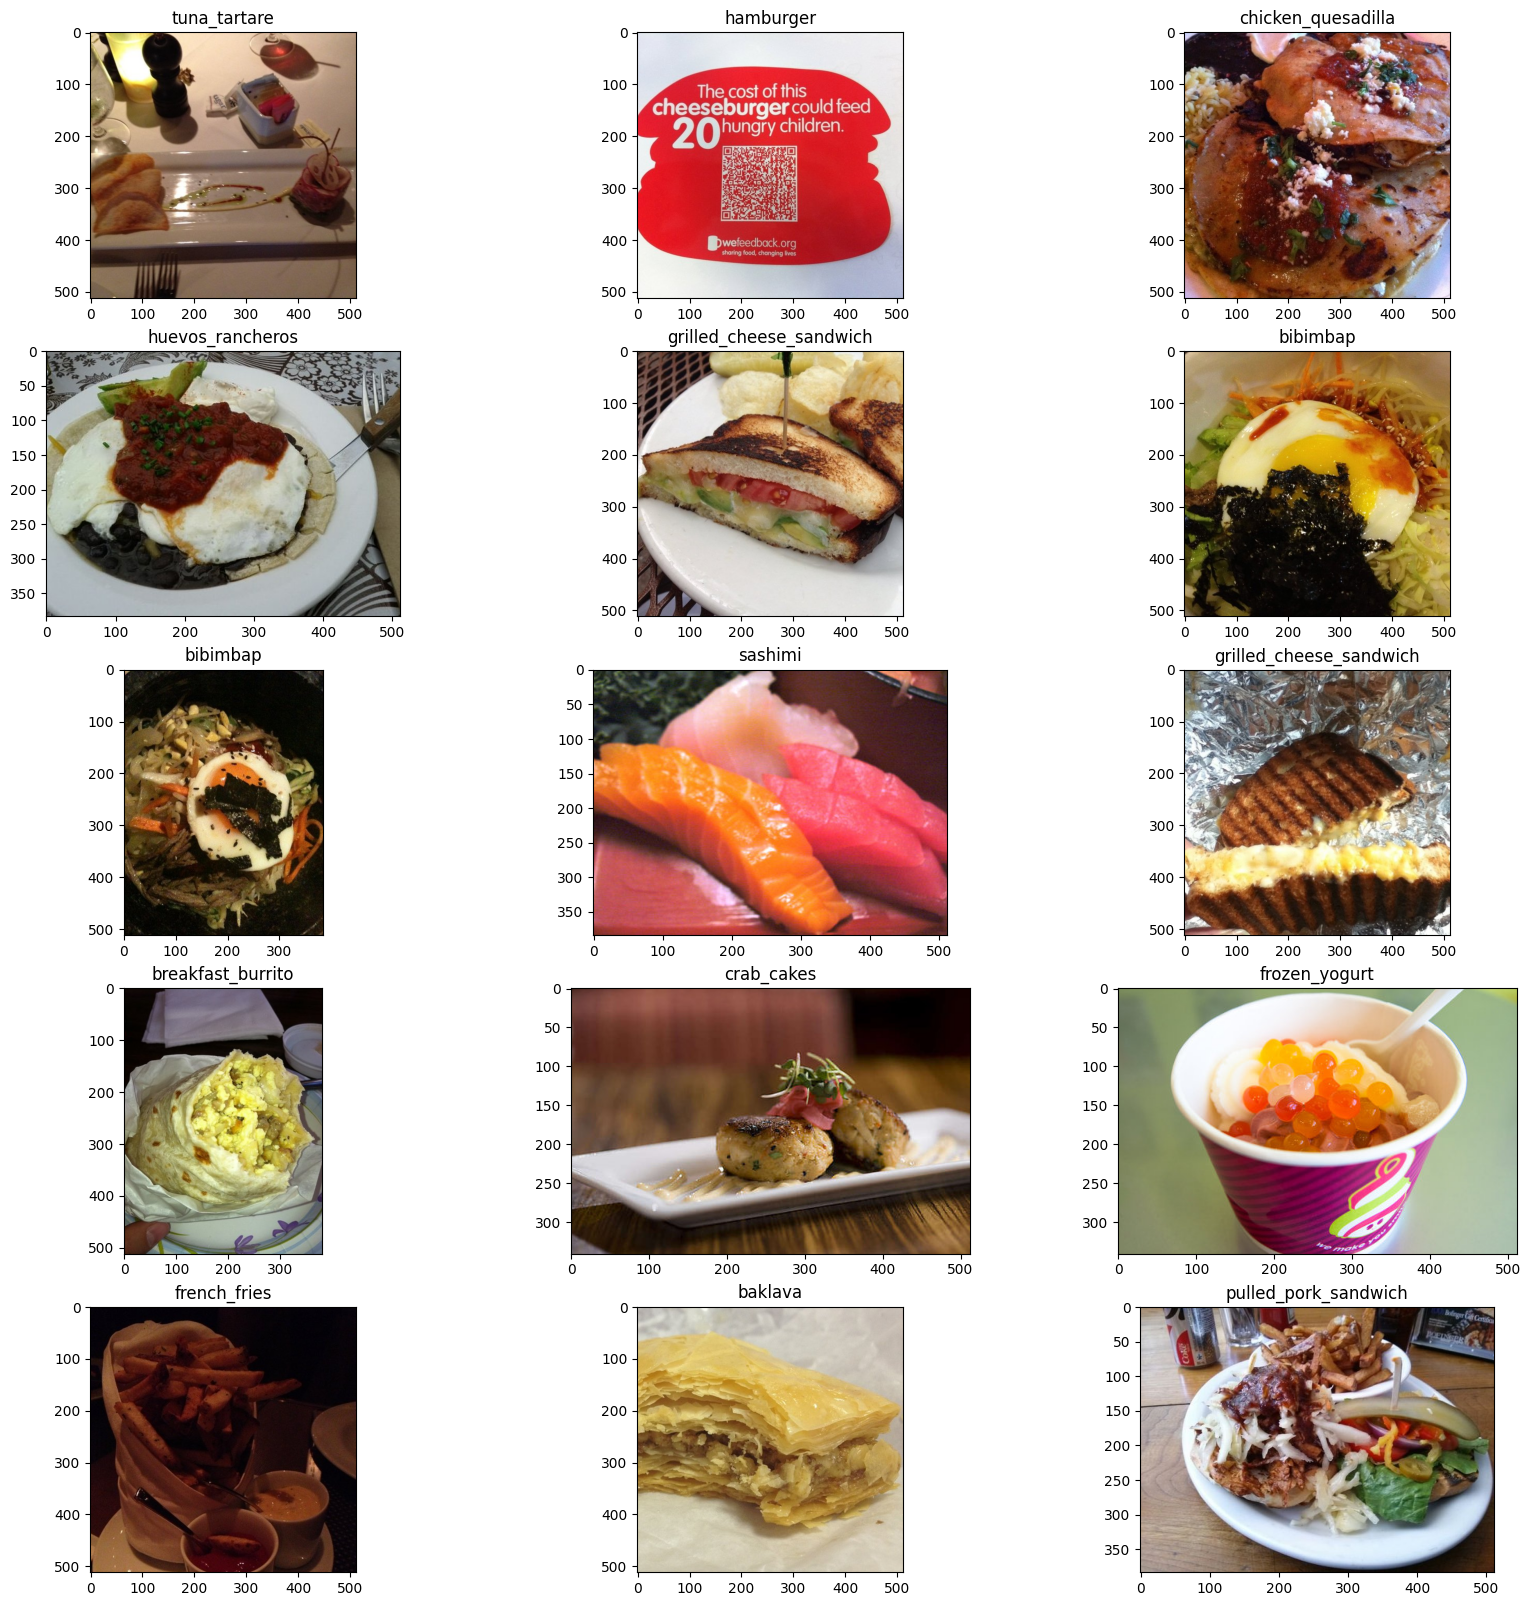

In [6]:
def visualisation(imgs, choise):
    
    fig, ax = plt.subplots(5, 3, figsize=(20, 20))
    fig.subplots_adjust()
    im_list = np.random.choice(imgs, choise)
    for axi, im in zip( ax.flat, im_list):
        axi.set_title(im.split('/')[5],)
        axi.imshow(plt.imread(im), )


visualisation(imgs, 15)

## Class distribution

In [7]:
counter_dict = {k:v for k,v in Counter(labels).items()} 
df = pd.DataFrame(counter_dict.items(),columns =['name', 'count'] )
df.describe()



,count
count,101.0
mean,1000.0
std,0.0
min,1000.0
25%,1000.0
50%,1000.0
75%,1000.0
max,1000.0


## median quantity imgs in class

In [11]:
len(imgs)/101

1000.0

## Make DF

In [6]:

df = pd.DataFrame(list(zip(imgs, labels)), columns =['X','y'])


In [13]:

df['y'].value_counts()

y
french_fries         1000
macarons             1000
french_toast         1000
lobster_bisque       1000
prime_rib            1000
                     ... 
beef_carpaccio       1000
poutine              1000
hot_and_sour_soup    1000
seaweed_salad        1000
foie_gras            1000
Name: count, Length: 101, dtype: int64

In [15]:
df['y'].value_counts().unique()

array([1000])

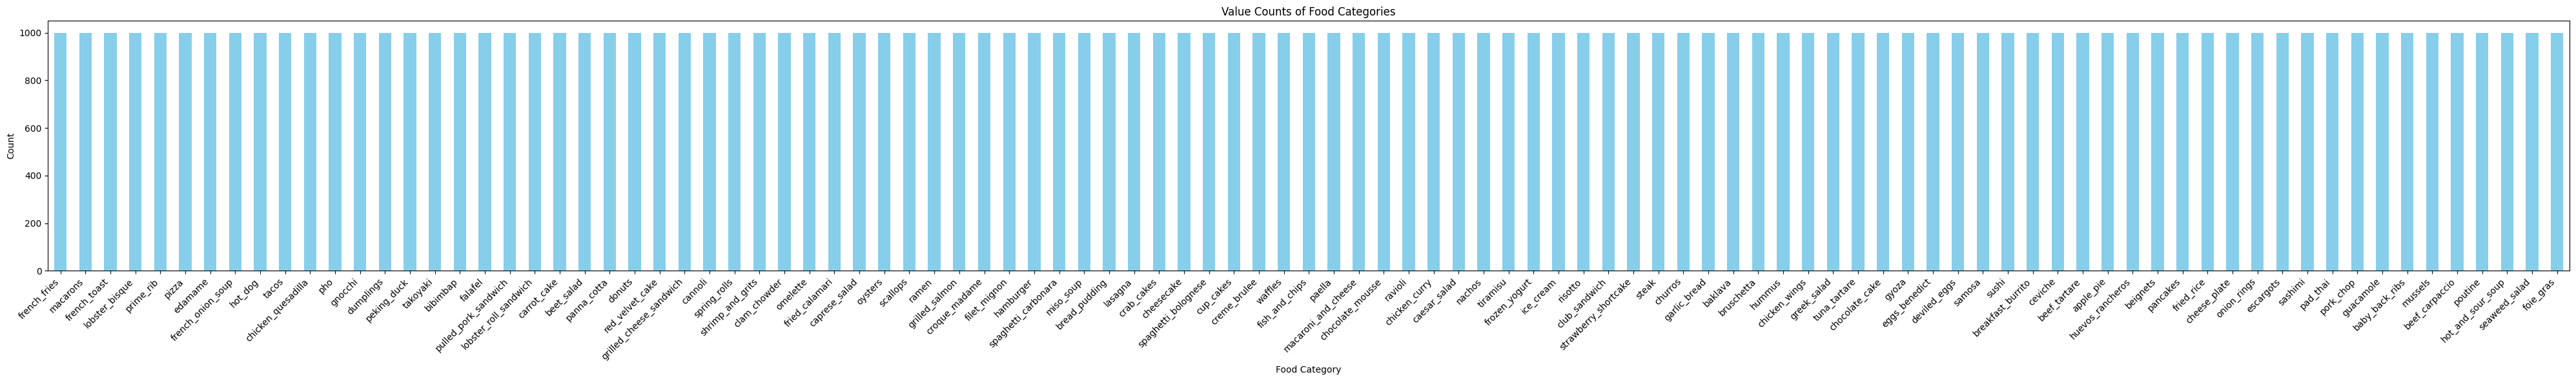

In [16]:


plt.figure(figsize=(40, 6))

df['y'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=11, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])


In [8]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,)
valid_gen = ImageDataGenerator(rescale=1./255)

In [9]:


train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)



Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


## Model

In [16]:
def build_model( num_classes=101, shape=(SIZE,SIZE,3)):
    
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB1(include_top=False, #EfficientNetB5
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout( 0.3, name="top_dropout")(x)
    x = tf.keras.layers.Dense(num_classes*4, activation="relu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))(x)
   
    x = tf.keras.layers.Dropout( 0.3, name="top_dropout_2")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
#kernel_initializer="he_normal",
                           #kernel_regularizer=keras.regularizers.l1(0.033)
    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB1")

    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        gamma=6,
        from_logits=False)
    
    learning_rate = 0.001
    

   
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

model = build_model()

In [18]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1.0000e-08) #0

epoch = 7
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )

Epoch 1/7
1317/1579 ━━━━━━━━━━━━━━━━━━━━ 3:26 787ms/step - accuracy: 0.0270 - loss: 43.7200

E0000 00:00:1739968222.447627     103 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1739968222.588741     103 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1739968227.634622     103 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1739968227.769569     103 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1769s 1s/step - accuracy: 0.0267 - loss: 39.1124 - val_accuracy: 0.0330 - val_loss: 9.5669 - learning_rate: 0.0010
Epoch 2/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1326s 837ms/step - accuracy: 0.0316 - loss: 9.6402 - val_accuracy: 0.0504 - val_loss: 9.6197 - learning_rate: 0.0010
Epoch 3/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1322s 834ms/step - accuracy: 0.0466 - loss: 9.6432 - val_accuracy: 0.0869 - val_loss: 9.8314 - learning_rate: 0.0010
Epoch 4/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1313s 829ms/step - accuracy: 0.0650 - loss: 6.1981 - val_accuracy: 0.1131 - val_loss: 6.1677 - learning_rate: 6.0000e-04
Epoch 5/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1321s 833ms/step - accuracy: 0.0705 - loss: 6.1923 - val_accuracy: 0.1044 - val_loss: 5.9960 - learning_rate: 6.0000e-04
Epoch 6/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1324s 836ms/step - accuracy: 0.0814 - loss: 6.1756 - val_accuracy: 0.0227 - val_loss: 6.2668 - learning_rate: 6.0000e-04
Epoch 7/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1323s 835ms

In [20]:
epoch = 7
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )

Epoch 1/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1340s 846ms/step - accuracy: 0.1703 - loss: 3.9089 - val_accuracy: 0.2797 - val_loss: 3.6919 - learning_rate: 3.6000e-04
Epoch 2/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1334s 842ms/step - accuracy: 0.2049 - loss: 3.8374 - val_accuracy: 0.3450 - val_loss: 3.7176 - learning_rate: 3.6000e-04
Epoch 3/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1325s 836ms/step - accuracy: 0.2411 - loss: 3.7756 - val_accuracy: 0.3937 - val_loss: 3.6202 - learning_rate: 3.6000e-04
Epoch 4/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1319s 833ms/step - accuracy: 0.2862 - loss: 3.7158 - val_accuracy: 0.4632 - val_loss: 3.6672 - learning_rate: 3.6000e-04
Epoch 5/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1318s 832ms/step - accuracy: 0.3258 - loss: 3.6691 - val_accuracy: 0.4871 - val_loss: 3.5253 - learning_rate: 3.6000e-04
Epoch 6/7
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 1325s 836ms/step - accuracy: 0.3632 - loss: 3.6296 - val_accuracy: 0.5406 - val_loss: 3.5761 - learning_rate: 3.6000e-04
Epoch 7/7
1579/1579 ━━━━━━━━

In [ ]:
epoch = 7
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )

Epoch 1/7
 394/1579 ━━━━━━━━━━━━━━━━━━━━ 13:13 669ms/step - accuracy: 0.4195 - loss: 3.5648

In [22]:
model.save('food101_efb1_2612_3ep2.h5')

## Metrics

In [ ]:

val = model.evaluate(test_gen)
test = model.evaluate(train_gen)

In [ ]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

show_history(history)

In [ ]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)


In [ ]:
y_train = train['y']
with pd.option_context("future.no_silent_downcasting", True):
    y_train = y_train.replace(training_generator.class_indices).infer_objects(copy=False)


#y_train = y_train.replace(training_generator.class_indices)
y_train = keras.utils.to_categorical(y_train, num_classes=9)



y_test = test['y']
with pd.option_context("future.no_silent_downcasting", True):
   y_test = y_test.replace(training_generator.class_indices).infer_objects(copy=False)
#y_test = y_test.replace(validation_generator.class_indices)
y_test = keras.utils.to_categorical(y_test, num_classes=9)


In [ ]:
def data_prepare(image_path, labels, class_dict, n_clases=9, target_size=(345, 345)):
    #X = np.array([])
    X = np.empty([len(image_path), target_size[0],target_size[1], 3])
    for i, img in enumerate(image_path): #tqdm(total=len(image_path))
        img = load_img(img, target_size=target_size)
        img_array = img_to_array(img)
        
        X[i,] = img

  
    y = [label.replace(key, str(value)) 
                for label in  labels
                for key, value in class_dict.items() 
                if key in label]
        
    y =  keras.utils.to_categorical(y, num_classes=n_clases)
    return X, y


In [ ]:
X_test_2, y_test_2 = data_prepare(X_test, y_test, training_generator.class_indices, target_size=(SIZE, SIZE),)
predictions_2 = model.predict(X_test_2)

In [ ]:
predictions = model.predict(test_gen)


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print(classification_report(true_classes, predicted_classes))

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('food101_efb1_2612.h5')

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('/kaggle/working/food101_efb1_81224.h5', 'food101_efb1_81224'))

In [ ]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()